In [22]:
import glob
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits

from spectra import *
from fitting import *

## Plotting data to see what it looks like...

In [23]:
fnames = glob.glob("data/science/*.nspec")

objects = {}
for fn in fnames:
    proplyd = ProplydData(fn)
    proplyd.x *= 1e4
    objects[proplyd.name] = proplyd

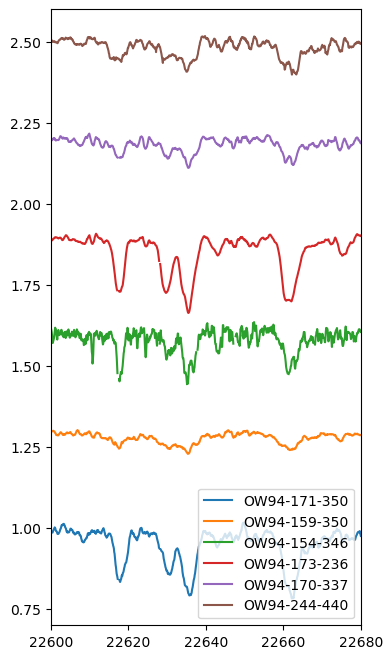

In [24]:
plt.figure(figsize=(4,8))
for i, (name,obj) in enumerate(objects.items()):
    plt.plot(obj.x, obj.y + i*0.3, label=obj.name)
plt.legend()
plt.ylim(0.7,2.6)
plt.xlim(22600,22680)
plt.show()

## Finding doppler shifts by hand

I set up a dictionary that will be converted to a CSV file later. I also find the Doppler shifts by hand in region 5 here. For now, I use the same shift for all regions. Later, you can see that the shifts are slightly off between wavelength regions. I need to automate the process of finding the shifts for each region individually...

In [25]:
best_models_dict = {"Name": ["Teff", "logg", "rK", "vsini", "B", "shift"]} # store all params here
shifts = np.zeros(len(objects))  # doppler shifts

In [26]:
# I determined these values using the code cell above
shifts = [-44, -40, -43, -43, -42, -40]

OW94-170-337


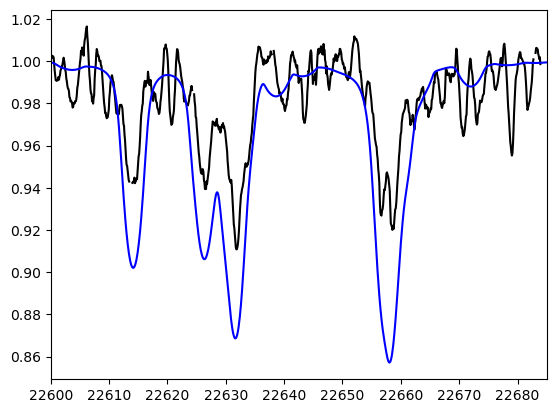

In [27]:
i = 4
name, obj = copy.deepcopy( list(objects.items())[i] )
#shifts[i] = -40
print(name)

xlo, xhi = 22600, 22684

# Visually determine the doppler shift, shift the data back
model = MoogStokesModel(4000, 4, rK=0, B=0, vsini=32, region=5)
model.apply_veiling(1)

shift = shifts[i]
obj.doppler_shift_data(shift)
xdata, ydata, yerrdata = obj.get_range(xlo, xhi)

# crop to xlo, xhi
mask = (xdata >= xlo) & (xdata <= xhi)
xdata = xdata[mask]
ydata = ydata[mask]
yerrdata = yerrdata[mask]

plt.figure()
plt.plot(xdata, ydata, c='k')
plt.plot(model.x, model.y, c='blue')
plt.xlim(model.x[0], model.x[-1])
plt.show()

In [29]:
Teff_vals = np.arange(3000, 5001, 600)
logg_vals = np.arange(2.75, 4.51, 0.5)
rK_vals = np.arange(0, 1.1, 0.2)
vsini_vals = np.arange(2, 43, 10)
B_vals = np.arange(0, 4, 2)

for i in range(6):
    name, obj = list(objects.items())[i]
    shift = shifts[i]

    # Make a copy so we can keep the data without the Doppler shift
    obj = copy.deepcopy(obj)
    obj.doppler_shift_data(shift)

    if name == "OW94-170-337":
        # Skip region 3 for this object
        regions = [0, 1, 2, 4, 5, 6]
    else:
        regions = range(7)
    chi2_grid = compute_moogstokes_chi2_grid(obj, Teff_vals, logg_vals, rK_vals, vsini_vals, B_vals, regions=regions)

    # Store best-fit parameters and shift for each object
    Teff, logg, rK, vsini, B = best_chi2_grid_params(chi2_grid, Teff_vals, logg_vals, rK_vals, vsini_vals, B_vals)
    best_models_dict[obj.name] = [Teff, logg, rK, vsini, B, shift]

Convert to a pandas dataframe and export as CSV

In [30]:
best_models = pd.DataFrame(data=best_models_dict)
best_models = best_models.T.reset_index()

new_header = best_models.iloc[0] #grab the first row for the header
best_models = best_models[1:] #take the data less the header row
best_models.columns = new_header #set the header row as the df header

best_models.to_csv("data/best_models.csv", index=False)

Read in the CSV

In [31]:
best_models = pd.read_csv("data/best_models.csv", index_col=False)
best_models = best_models.set_index("Name")  # remove index column
best_models

,Teff,logg,rK,vsini,B,shift
Name,,,,,,
OW94-171-350,3600.0,3.75,0.8,22.0,2.0,-44.0
OW94-159-350,4800.0,4.25,1.0,42.0,0.0,-40.0
OW94-154-346,4800.0,4.25,1.0,12.0,0.0,-43.0
OW94-173-236,4200.0,3.75,0.4,22.0,2.0,-43.0
OW94-170-337,4800.0,4.25,1.0,32.0,0.0,-42.0
OW94-244-440,4800.0,4.25,1.0,42.0,0.0,-40.0


In [32]:
def get_moogstokes_from_df(best_models_df, name, region):
    result = best_models_df.loc[name]
    Teff = result["Teff"]
    logg = result["logg"]
    rK = result["rK"]
    vsini = result["vsini"]
    B = result["B"]
    shift = result["shift"]
    model = MoogStokesModel(Teff, logg, rK, B, vsini, region)
    return model

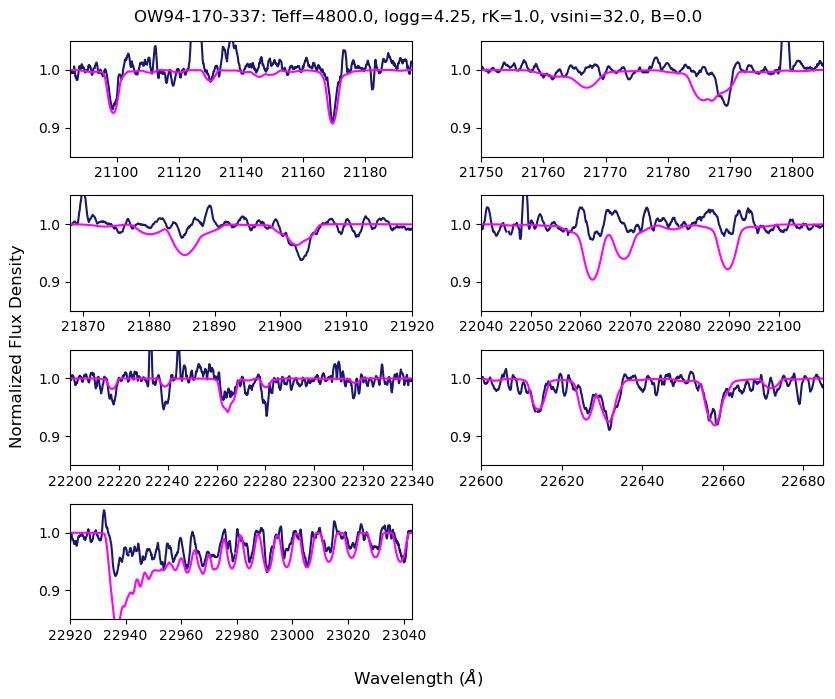

In [33]:
name = "OW94-170-337"
obj = copy.deepcopy( objects[name] )

shift = best_models.loc[name, "shift"]
obj.doppler_shift_data(shift)

xmodel = []
ymodel = []
xlo = []
xhi = []
for region in range(7):
    model = get_moogstokes_from_df(best_models, name, region)
    xmodel.append(model.x)
    ymodel.append(model.y)
    xlo.append(model.x[0])
    xhi.append(model.x[-1])
xmodel = np.concatenate(xmodel)
ymodel = np.concatenate(ymodel)


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8.5,7))

for r, ax in enumerate(axs.reshape(-1)):
    if r == 7:
        ax.axis("off")
        continue
    ax.plot(obj.x, obj.y, c='midnightblue')
    ax.plot(xmodel, ymodel, c='magenta')
    ax.set_ylim(0.85,1.05)
    ax.set_xlim(xlo[r], xhi[r])
fig.suptitle(f"{name}: Teff={model.Teff}, logg={model.logg}, rK={round(model.rK,2)}, vsini={model.vsini}, B={model.B}")
fig.supxlabel(r"Wavelength ($\AA$)")
fig.supylabel(r"Normalized Flux Density")
plt.tight_layout()
#fig.savefig(f"figures/model_plots/{name}_Teff{model.Teff}_logg{model.logg}_rK{round(model.rK,2)}_vsini{model.vsini}_B{model.B}.png", dpi=98, facecolor="white")
plt.show()

## Plot with Feiden (2016) magnetic isochrones

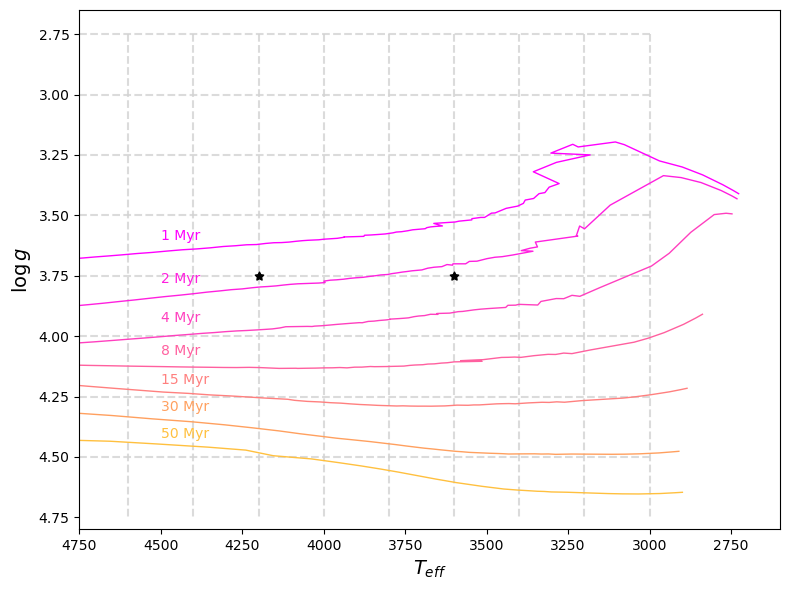

In [34]:
# Import isochrones
model_ages = [1, 2, 4, 8, 15, 30, 50]          # in Myr
iso_models = []

for num in model_ages:
    fname = 'data/isochrones/dmestar_' + str(num) +'myr.txt'
    arr = np.loadtxt(fname, skiprows=5).T
    m = arr[0]
    teff = 10**arr[1]      # convert from logTeff to Teff
    logg = arr[2]
    iso_models.append([m, teff, logg])

plt.figure(figsize=(8,6))

# Isochrones and labels
n = 9
tshifts = [0, 0.02, 0.02, 0, -0.04, -0.09, -0.14]
colors = plt.cm.spring(np.linspace(0,1,n))
for i in range(len(model_ages)):
    plt.plot(iso_models[i][1], iso_models[i][2], zorder=1, label=str(model_ages[i]) + ' Myr', linewidth=1, c=colors[i])
    plt.text(4500, 3.6+0.16*i+tshifts[i], f"{model_ages[i]} Myr", c=colors[i], zorder=1)

# Proplyds
Teffs = []
loggs = []
names = []
for row in best_models.iterrows():
    names.append(row[0])
    Teffs.append(row[1]["Teff"])
    loggs.append(row[1]["logg"])

plt.scatter(Teffs, loggs, c='k', marker=(5, 1), s=40, zorder=2)
plt.vlines(np.arange(3000, 4800, 200), 2.75, 4.75, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)
plt.hlines(np.arange(2.75, 4.51, 0.25), 3000, 4800, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)


plt.xlim(2600, 4750)
plt.ylim(2.65, 4.8)
plt.xlabel(r'$T_{eff}$', fontsize=14)
plt.ylabel(r'$\log g$', fontsize=14)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
#plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('figures/ages.png', facecolor='white', dpi=98)
plt.show()